In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

from keras.preprocessing.text import text_to_word_sequence
from sklearn.model_selection import train_test_split

import re

Using TensorFlow backend.


In [3]:
import os,sys,inspect
currentdir=os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir=os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
from src import preprocessing

In [4]:
#definition constants
RANDOM_STATE = 11
TARGET_METRIC = 'f1'
TEST_SIZE = 0.15


In [5]:
# import & display data
data = pd.read_csv('../../data/IMDB_Dataset.csv')
data['sentiment'] = data['sentiment'].replace({'positive' : 1, 'negative' : 0})
data = data.drop_duplicates()
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [6]:
X = data.review
y = data.sentiment
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE, 
                                                    stratify = y)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, 
#                                                     y_train,
#                                                     test_size=TEST_SIZE, 
#                                                     random_state=RANDOM_STATE, 
#                                                     stratify = y_train)

### Preprocessing Data

In [24]:
MAX_FEATURES = 50000

vectorizer = TfidfVectorizer(ngram_range=(1,2), preprocessor=preprocessing.preprocessing_text, max_features=MAX_FEATURES)

vectorizer.fit(X_train)
X_train_features = vectorizer.transform(X_train)
X_valid_features = vectorizer.transform(X_valid)
X_test_features = vectorizer.transform(X_test)

In [28]:
batch_size = 50
epochs = 30
callback = EarlyStopping(monitor='val_loss', patience=3)

# Create the model
model = Sequential()
model.add(Dense(64, input_shape=(MAX_FEATURES,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
    
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


history = model.fit(X_train_features, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[callback],
                    verbose=1,
                    validation_data=(X_valid_features, y_valid),
                   shuffle=True,)


Train on 35822 samples, validate on 6322 samples
Epoch 1/30
35822/35822 [==============================] - 52s 1ms/step - loss: 0.2978 - acc: 0.8812 - val_loss: 0.2041 - val_acc: 0.9192
Epoch 2/30
35822/35822 [==============================] - 50s 1ms/step - loss: 0.0707 - acc: 0.9778 - val_loss: 0.2575 - val_acc: 0.9111
Epoch 3/30
35822/35822 [==============================] - 46s 1ms/step - loss: 0.0159 - acc: 0.9959 - val_loss: 0.3567 - val_acc: 0.9054
Epoch 4/30
35822/35822 [==============================] - 46s 1ms/step - loss: 0.0035 - acc: 0.9992 - val_loss: 0.4448 - val_acc: 0.9075


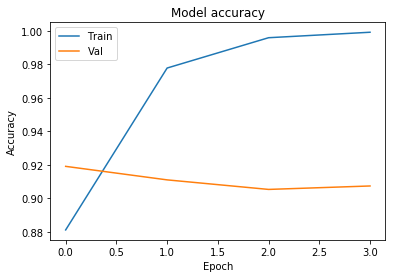

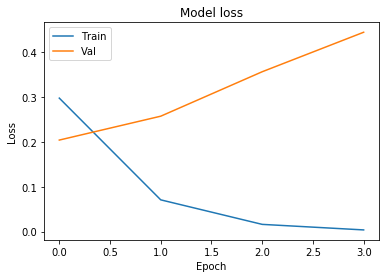

In [29]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [8]:
# callback = EarlyStopping(monitor='val_loss', patience=3)

# Create the model
def create_model(dropout=0.1,  dense_nparams=256, optimizer='adam',
                 kernel_initializer='uniform',):
    model = Sequential()
    model.add(Dense(dense_nparams, input_shape=(MAX_FEATURES,), activation='relu', kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
#     for layer_size in dense_layer_sizes:
#         model.add(Dense(layer_size, activation='relu'))
#         model.add(Dropout(dropout), )
    model.add(Dense(dense_nparams, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model


In [10]:
MAX_FEATURES = 50000
keras_classifier = KerasClassifier(build_fn=create_model, verbose=1)
mlp_estimator = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2), 
                                                    preprocessor=preprocessing.preprocessing_text, 
                                                    max_features=MAX_FEATURES)),  
                       ("kc", keras_classifier)])

param_grid = {
#     'kc__epochs': [10, 100, ],
    'kc__dense_nparams': [32, 256, 512],
#     'kc__kernel_initializer': [ 'uniform', 'zeros', 'normal', ], 
#     'kc__batch_size':[2, 16, 32],
#     'kc__optimizer':['RMSprop', 'Adam', 'Adamax', 'sgd'],
    'kc__dropout': [0.5, 0.4, 0.3, 0.2, 0.1, 0]
}

In [11]:

grid = GridSearchCV(estimator=mlp_estimator,  
                    n_jobs=1, 
                    verbose=1,
                    return_train_score=True,
                    param_grid=param_grid,)


grid_result = grid.fit(X_train, y_train)

C:\Users\Tatsiana_Drabysheusk\AppData\Local\Continuum\miniconda3\envs\Project_New\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
28096/28096 [==============================] - 136s 5ms/step
Epoch 1/1
28096/28096 [==============================] - 123s 4ms/step
Epoch 1/1
28096/28096 [==============================] - 104s 4ms/step
Epoch 1/1
28096/28096 [==============================] - 107s 4ms/step
Epoch 1/1
28096/28096 [==============================] - 119s 4ms/step
Epoch 1/1
28096/28096 [==============================] - 139s 5ms/step
Epoch 1/1
28096/28096 [==============================] - 122s 4ms/step
Epoch 1/1
28096/28096 [==============================] - 111s 4ms/step
Epoch 1/1
28096/28096 [==============================] - 132s 5ms/step
Epoch 1/1
28096/28096 [==============================] - 103s 4ms

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 402.5min finished


Epoch 1/1
42144/42144 [==============================] - 47s 1ms/step - loss: 0.2929 - acc: 0.8799


https://medium.com/@am.benatmane/keras-hyperparameter-tuning-using-sklearn-pipelines-grid-search-with-cross-validation-ccfc74b0ce9f

In [37]:
    grid_result.best_estimator_.steps[1][1].model.get_config()

{'name': 'sequential_55',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_163',
    'trainable': True,
    'batch_input_shape': (None, 50000),
    'dtype': 'float32',
    'units': 32,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_55',
    'trainable': True,
    'rate': 0.4,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_164',
    'trainable': True,
    'units': 32,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_

In [34]:
def search_huperparams():
    

SyntaxError: unexpected EOF while parsing (<ipython-input-34-05d82208da29>, line 2)